<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#The-Bayesian-bandit-problem" data-toc-modified-id="The-Bayesian-bandit-problem-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The Bayesian bandit problem</a></span><ul class="toc-item"><li><span><a href="#Exercise-1" data-toc-modified-id="Exercise-1-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Exercise 1</a></span></li></ul></li><li><span><a href="#Multiple-bandits" data-toc-modified-id="Multiple-bandits-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multiple bandits</a></span><ul class="toc-item"><li><span><a href="#Exercise-2" data-toc-modified-id="Exercise-2-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Exercise 2</a></span></li><li><span><a href="#Exercise-3" data-toc-modified-id="Exercise-3-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Exercise 3</a></span></li></ul></li></ul></div>

# Introduction

This notebook contains solutions to the [bandit notebook](https://github.com/AllenDowney/BayesMadeSimple/blob/master/04_bandit_soln.ipynb). 

# Libraries

In [1]:
using Gen
using Statistics
using Plots
using DataStructures
using Printf
using StatsPlots

In [2]:
include("../src/utils.jl");

# The Bayesian bandit problem

Suppose you have several "one-armed bandit" slot machines, and reason to think that they have different probabilities of paying off.

Each time you play a machine, you either win or lose, and you can use the outcome to update your belief about the probability of winning.

Then, to decide which machine to play next, you can use the "Bayesian bandit" strategy, explained below.

## Exercise 1

**Question**

Suppose you play a machine 10 times and win once. What is the posterior distribution of $x$?

**Solution**

Model the problem:

In [3]:
@gen function pull_lever(pulls::Int)
    prob_win = @trace(uniform_discrete(0, 100), :prob_win)
    for i in 1:pulls
        @trace(bernoulli(prob_win/100), (:outcome, i))
    end
end;

Sample the posterior:

In [4]:
outcomes = Array{Integer, 1}()
observations = Gen.choicemap()

for i in 1:9
    observations[(:outcome, i)] = 0
end

observations[(:outcome, 10)] = 1

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(pull_lever, (10,), observations, 100)
    push!(outcomes, trace[:prob_win])
    
end

Plot the distribution:

In [5]:
function plot_distribution(outcomes::Array{Integer, 1}, title::String)
    bins = length(unique(outcomes))
    histogram(outcomes, 
              legend=false, 
              xlabel="Probability of winning", 
              ylabel="PMF", 
              title=title, 
              normalize=:probability, 
              bins=bins)
end;

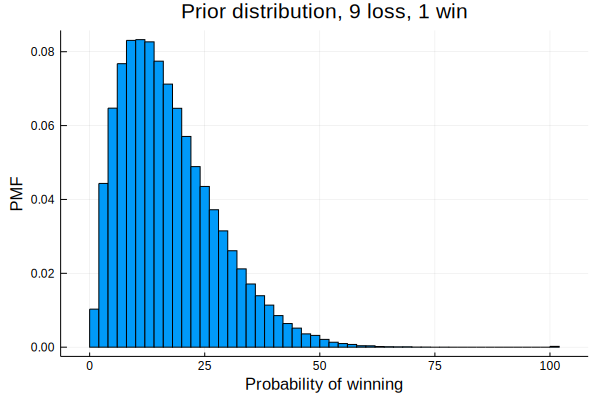

In [6]:
plot_distribution(outcomes, "Prior distribution, 9 loss, 1 win")

In [7]:
@sprintf "The MAP is %.2f" compute_map(outcomes)/100

"The MAP is 0.12"

# Multiple bandits


Now suppose we have several bandits and we want to decide which one to play.

For this example, we have 4 machines with these probabilities of winnning:

* machine 1: 0.10
* machine 2: 0.20
* machine 3: 0.30
* machine 4: 0.40

## Exercise 2

Play each machine 10 times, then plot the posterior distributions.

Model the problem:

In [8]:
@gen function play_machine(machine_id::Integer, pulls::Integer)
    machine_probs = [0.1, 0.2, 0.3, 0.4]
    machine_prob = machine_probs[machine_id]
    
    for i in 1:pulls
        @trace(bernoulli(machine_prob), (:outcome, i))
    end    
end;

In [9]:
@gen function update_belief(machine_id::Integer, pulls::Integer)
    prob_win = @trace(uniform_discrete(0, 100), :prob_win)
    for i in 1:pulls
        @trace(bernoulli(prob_win/100), (:outcome, i))
    end
end;

Plot the priors:

In [10]:
function plot_distribution(outcomes::Array{Integer, 1}, machine_id::String)
    bins = length(unique(outcomes))
    h = histogram(outcomes, legend=false, title="Machine $machine_id", normalize=:probability, bins=bins)
    return h
end;

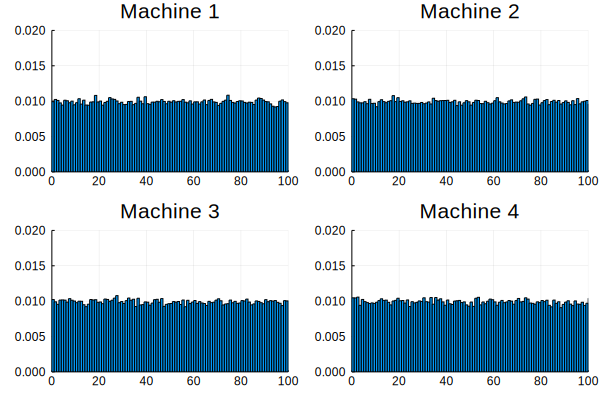

In [11]:
ps = []

for i in 1:4
    machine_id = i

    outcomes = Array{Integer, 1}()
    for i in 1:100000
        (trace, __) = Gen.generate(update_belief, (machine_id, 1))
        push!(outcomes, trace[:prob_win])
    end
    
    p = plot_distribution(outcomes, string(machine_id))
    push!(ps, p)
    
end

plot(ps..., layout=(2, 2), xlim=(0, 100), ylim=(0, 0.02))

Plot the posteriors and compute the MAP and credible intevals:

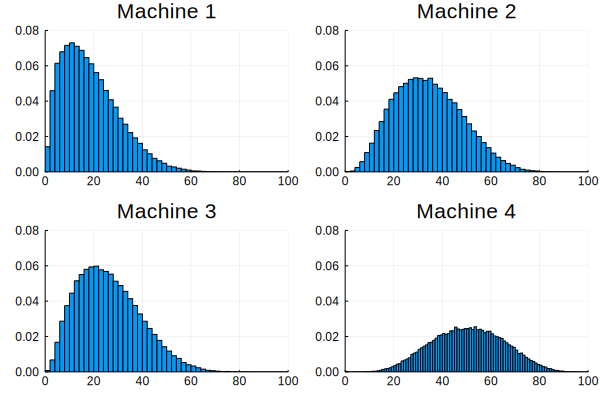

In [12]:
ps = []
maps = []
credible_intervals = []

for i in 1:4
    machine_id = i
    pulls = 10
    
    (trace1, _) = Gen.generate(play_machine, (machine_id, pulls))
    observations = get_choices(trace1)

    outcomes = Array{Integer, 1}()
    for i in 1:100000
        (trace2, __) = Gen.importance_resampling(update_belief, (machine_id, pulls), observations, 10)
        push!(outcomes, trace2[:prob_win])
    end
    
    p = plot_distribution(outcomes, string(machine_id))
    push!(ps, p)
    push!(maps, compute_map(outcomes))
    push!(credible_intervals, compute_credible_interval(outcomes, 0.90))
end

plot(ps..., layout=(2, 2), xlim=(0, 100), ylim=(0, 0.08))

In [13]:
for i in 1:4
    println("Machine $i: $(maps[i]/100) $(credible_intervals[i] ./ 100)")
end

Machine 1: 0.11 (0.03, 0.4)
Machine 2: 0.29 (0.13, 0.58)
Machine 3: 0.21 (0.07, 0.49)
Machine 4: 0.53 (0.26, 0.74)


## Exercise 3

Implement the Bayesian Bandits algorithm.

We start with the belief that each machine's probability of winning is uniformly distributed:

In [14]:
prior = [1/101 for i in 1:101];

A function to play a machine once:

In [15]:
@gen function play_machine(machine_id::Integer)
    machine_probs = [0.1, 0.2, 0.3, 0.4]
    machine_prob = machine_probs[machine_id]

    @trace(bernoulli(machine_prob), :outcome)
        
end;

We choose a machine based on our beliefs. The machine which we belief is the most profitable is likely to get picked more often:

In [16]:
function choose_machine(beliefs::Array{Array{Float64, 1}, 1})::Integer
    sampled_beliefs = [categorical(belief) for belief in beliefs]
    machine_choice = argmax(sampled_beliefs)
    
    return machine_choice
end;

A functions to update a belief about a machine:

In [17]:
@gen function update_prior(belief::Array{Float64, 1})
    prob_win = @trace(categorical(belief), :prob_win)
    prob_win = (prob_win - 1)/100
    @trace(bernoulli(prob_win), :outcome)
end;

In [18]:
function build_new_beliefs(outcome_counts::Accumulator{Integer,Int64}, trials::Integer)::Array{Float64, 1}
    
    new_belief_probs = zeros(101)
    
    for (k,v) in outcome_counts
        new_belief_probs[k] = v/trials
    end
    
    return new_belief_probs
end;

In [19]:
function update_machine_belief(machine_id::Integer, 
                               beliefs::Array{Array{Float64, 1}, 1}, 
                               observations::DynamicChoiceMap,
                               trials::Integer)::Array{Array{Float64, 1}, 1}
    
    updated_beliefs = copy(beliefs)
    belief_probs = beliefs[machine_id]
    
    outcomes = Array{Integer, 1}()
    for i in 1:trials
        (trace, _) = Gen.importance_resampling(update_prior, (belief_probs,), observations, 10)
        push!(outcomes, trace[:prob_win])
    end
    
    outcome_counts = counter(outcomes)
    new_belief_probs = build_new_beliefs(outcome_counts, trials)
    
    updated_beliefs[machine_id] = new_belief_probs
    
    return updated_beliefs
    
end;

Run the algorithm:

In [20]:
beliefs = [prior for _ in 1:4]

num_plays = 200
choice_counts = counter(Integer)

for _ in 1:num_plays
    machine_choice = choose_machine(beliefs)
    inc!(choice_counts, machine_choice)

    outcome_trace, _ = Gen.generate(play_machine, (machine_choice,))
    machine_outcome = Gen.choicemap(get_choices(outcome_trace))

    beliefs = update_machine_belief(machine_choice, beliefs, machine_outcome, 1000)
end

Look at number of times each machine was played:

In [21]:
for i in 1:4
    out = @sprintf "Machine %d : %3d (%.2f)" i choice_counts[i] choice_counts[i]/num_plays
    println(out)
end

Machine 1 :  23 (0.12)
Machine 2 :  18 (0.09)
Machine 3 :  30 (0.15)
Machine 4 : 129 (0.65)


As expected, the machine with the highest true probability of winning is played the most often.

Compute the MAP and credible intervals:

In [22]:
function generate_outcomes_from_beliefs(belief)
    outcomes = Array{Integer, 1}()
    for _ in 1:100000
        trace, _ = Gen.generate(update_prior, (belief,))
        outcome =  trace[:prob_win] - 1
        push!(outcomes, outcome)
    end
    return outcomes
end;

In [23]:
for i in 1:4
    outcomes = generate_outcomes_from_beliefs(beliefs[i])
    println("Machine $i : $(compute_map(outcomes)/100) $(compute_credible_interval(outcomes) ./ 100)")
    
end

Machine 1 : 0.13 (0.05, 0.34)
Machine 2 : 0.22 (0.03, 0.32)
Machine 3 : 0.18 (0.09, 0.35)
Machine 4 : 0.33 (0.28, 0.44)


Plot the beliefs:

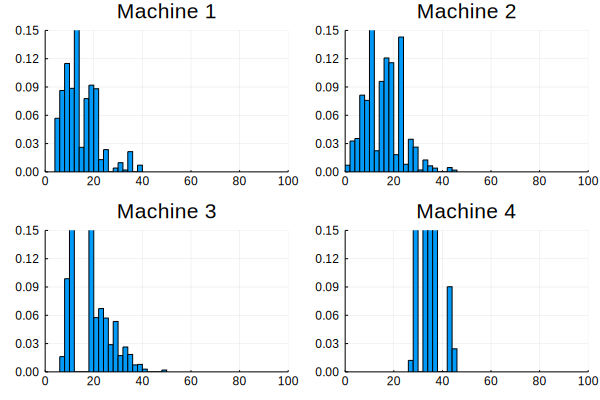

In [24]:
ps = []

for i in 1:4
    outcomes = generate_outcomes_from_beliefs(beliefs[i])
    p = plot_distribution(outcomes, string(i))
    push!(ps, p)
end

plot(ps..., layout=(2,2))
xlims!(0, 100)
ylims!(0, 0.15)